In [5]:
import pandas as pd
import openpyxl as px
import os 
import psycopg2 as pg
import configparser
import numpy as np
from python_calamine.pandas import pandas_monkeypatch
pandas_monkeypatch()
from datetime import datetime

In [6]:
#Credenciais

crendenciais_path = r'F:\Silvicultura\01. SP\PROCESSOS\COI Silvicultura - Edicao\04. Pessoas\Gabriel Moura\00 - Silvicultura\00 - Credenciais\credenciais.conf'

In [7]:
#path premissas 
path_premissas = r'F:\Silvicultura\01. SP\PROCESSOS\COI Silvicultura - Edicao\01. Programações & Controles\001. Rolling Forcast - RF\Distribuição Regional\premissas.xlsx'

In [8]:
#Mascara mês operacional

def mes_operacional(df, coluna, nome_coluna):
    # Garantir que a coluna é do tipo datetime
    if not pd.api.types.is_datetime64_any_dtype(df[coluna]):
        df[coluna] = pd.to_datetime(df[coluna], errors='coerce')
    
    
    def calcular_mes_operacional(data):
        
        if pd.isna(data):
            return None 
        
        
        dia = data.day
        mes = data.month
        ano = data.year
        
        
        if dia > 20:
            mes = (mes % 12) + 1
            if mes == 1:
                ano += 1
        
        # Retornar um Timestamp, garantindo que todos são inteiros
        return pd.Timestamp(year=int(ano), month=int(mes), day=1)

    # Aplicar a função para a coluna
    df[nome_coluna] = df[coluna].apply(calcular_mes_operacional)

    return df

In [9]:
#Encontrando o dia atual

# Obter a data de hoje
today = datetime.today()

# Aplicar a lógica diretamente na variável
dia = today.day
mes = today.month
ano = today.year

if dia > 20:
    mes = (mes % 12) + 1
    if mes == 1:
        ano += 1

# Criar o Timestamp correspondente ao primeiro dia do mês operacional
mes_operacional_vigente = pd.Timestamp(year=ano, month=mes, day=1)

In [10]:
#def Premissas

premissas_df = pd.read_excel(path_premissas, sheet_name='path')

def input_file(file):
    premissas = premissas_df.copy()
    
    premissas = premissas[premissas['status'] == 'ativo']

    premissas = premissas[premissas['arquivos de consumo'] == file]

    path = premissas['path'].iloc[0]

    return path

In [11]:
#Fase de operações

fase_op = pd.read_excel(path_premissas, sheet_name='fase_op', usecols=['Plantio', 'Operação'])

fase_op = fase_op[fase_op['Plantio'] == 'Sim']

fase_op_list = list(fase_op['Operação'])

fase_op = list(fase_op['Operação'])


#List comprehension em todos os itens da fase de operação

fase_op = ", ".join(f"'{op}'" for op in fase_op)

In [12]:
#Senhas e credênciais 

credenciais = configparser.ConfigParser()

credenciais.read(crendenciais_path)

logins = credenciais['credenciais']


conn_dwh = pg.connect(
    user =logins['login'],
    password =logins['senha_sql'],
    host = logins['host'],
    port = logins['port'],
    database = logins['data_base']
)

In [13]:
#Boletim

cursor_boletim = conn_dwh.cursor()

cursor_boletim.execute(

f"""


WITH material_unico AS (
    SELECT DISTINCT ON (cd_material_genetico)
           *
    FROM forestry.f_sgf_lb_con_base_dim
    WHERE source = 'BSP'
    )


select
f.cd_boletim_silvicultura,
f.dcr_ordem_servico,
f.data_operacao, 
f.nom_projeto,
f.id_projeto,
f.cd_talhao,
f.vlr_producao,
f.dcr_operacao,
f.dcr_contrato,
f.dcr_fornecedor,
f.dcr_usuario,
f.cd_fornecedor,
f.tip_aprovacao,
f.abrev_unidade_medida,
f.nome_recurso,
f.quantidade,
f.qtd_descarte,
f.cd_material_genetico,
f.dcr_localidade,
f.cd_item_motivo,
d.dcr_item_motivo,
m.dcr_material_genetico


FROM forestry.vw_f_vw_sil_cons_completa_boletim_bsp_all f

LEFT JOIN forestry.d_cfg_item_motivo d

    ON d.cd_item_motivo = f.cd_item_motivo
    
LEFT JOIN material_unico m

    ON m.cd_material_genetico = f.cd_material_genetico

where 
f.dcr_operacao in( {fase_op}) and
m.source = 'BSP' and
f.source = 'BSP' and 
f.tip_aprovacao <> 'C' and 
f.data_operacao >= '2023-12-21' and
(d.source = 'BSP' or d.source isnull) and
(d.est_reg = 'A' or d.est_reg isnull)

"""

)

dados_boletim  = cursor_boletim.fetchall()


#Fechando as conexões
cursor_boletim.close()


colunas_boletim = [desc[0] for desc in cursor_boletim.description]

boletim = pd.DataFrame(dados_boletim, columns=colunas_boletim)

boletim['origem'] = 'Boletim'

boletim['vlr_producao'] = pd.to_numeric(boletim['vlr_producao'], errors='coerce')

boletim['quantidade'] = pd.to_numeric(boletim['quantidade'], errors='coerce')

boletim['qtd_descarte'] = pd.to_numeric(boletim['qtd_descarte'], errors='coerce')

In [14]:
#Consumo de mudas

boletim['Consumo de mudas plantadas / ha'] = round(boletim['quantidade'] / boletim['vlr_producao'],0) 

boletim['Consumo de mudas total / ha'] = round((boletim['quantidade']  + boletim['qtd_descarte']),0) 


In [15]:
#Cadastro

cursor_cadastro = conn_dwh.cursor()

cursor_cadastro.execute(

f"""

SELECT 
    f.data_plantio,
    f.cd_regiao,
    f.id_projeto,
    f.cd_projeto,
    f.cd_talhao,
    f.num_ciclo,
    f.cd_regime,
    f.num_rotacao,
    f.vlr_area,
    f.source,
    f.data_reg,
    f.est_reg,
    f.cd_uso_solo,
    f.cd_caracteristica_uso_solo,
    f.cd_espacamento,
    d.dcr_espacamento,
    p.nom_projeto,
    f.dcr_extra_08,
    f.dcr_extra_07,
    c.dcr_caracteristica_uso_solo
    
FROM 
    forestry.f_cfg_uso_solo f
LEFT JOIN 
    forestry.d_cfg_espacamento d
ON 
    f.cd_espacamento = d.cd_espacamento
    
LEFT JOIN 
    forestry.cfg_projeto p

ON
    f.id_projeto = p.id_projeto

left join 
	forestry.f_cfg_caracteristica_uso_solo c
	
on 
	c.cd_caracteristica_uso_solo = f.cd_caracteristica_uso_solo
	
	    
    
WHERE 
	c.source = 'BSP'
	and c.est_reg = 'A'
    and f.source = 'BSP'
    AND p.source = 'BSP'
    AND p.cd_regiao in ('1','2')
    AND p.est_reg = 'A'
    and f.est_reg = 'A'
    AND f.tip_reg = 'A'  
    AND f.cd_regiao IN ('1','2') ;



"""

)

dados_cto_baldeio  = cursor_cadastro.fetchall()



#Fechando as conexões
cursor_cadastro.close()


colunas_cadastro = [desc[0] for desc in cursor_cadastro.description]

cadastro = pd.DataFrame(dados_cto_baldeio, columns=colunas_cadastro)

In [16]:
#Cadastro 


cadastro = cadastro.rename({'dcr_extra_08': 'CZ', 'dcr_extra_07':'regional operacional'}, axis = 1)

cadastro['Objeto de locação'] = cadastro['id_projeto'].astype(str) + cadastro['cd_talhao'].astype(str)


cadastro = cadastro.drop_duplicates('Objeto de locação')

In [17]:
#Filtrando insumos no boletim

boletim = boletim[(boletim['nome_recurso'] == 'Mudas De Eucalipto') | (boletim['nome_recurso'] == 'Muda Eucalipto Terceiros')]

boletim['Objeto de locação'] = boletim['id_projeto'].astype(str) + boletim['cd_talhao'].astype(str)

In [18]:
#Boletim & Cadastro
boletim = boletim.merge(cadastro[['cd_regiao', 'Objeto de locação','CZ','regional operacional']], on= 'Objeto de locação', how = 'left')


#Filtrando MS
boletim = boletim[boletim['cd_regiao'] == 1]

In [19]:
#Mês operacional

boletim = mes_operacional(df=boletim, coluna='data_operacao', nome_coluna='Mês Operacional')

In [20]:
#De para EPS

de_para_eps = pd.read_excel(path_premissas, sheet_name='eps')


boletim['os_eps'] = boletim.apply(lambda x : str(x['dcr_ordem_servico'])[8:].split('_')[1].upper(), axis=1)

boletim['dcr_fornecedor'] = np.where(boletim['dcr_fornecedor'] == 'J F I SILVICULTURA', boletim['os_eps'], boletim['dcr_fornecedor'])

boletim['dcr_fornecedor'] = np.where( (boletim['os_eps'] == 'JFI') & (boletim['dcr_usuario'] == 'Danilo Roberto Bavaroski') , 'JFICAPÃO', boletim['dcr_fornecedor'])


#de_para eps
boletim = boletim.merge(de_para_eps, left_on=['dcr_fornecedor'], right_on=['eps_de'],how='left').drop('eps_de',axis=1).rename({'eps_para': 'Equipe de Plantio'},axis=1)

In [21]:
#Rehab Controladoria

rehab_control_path = input_file('path_rehab_control')

rehab_control = pd.read_excel(rehab_control_path,
                              sheet_name='BD_oficial',
                              dtype={'ID DE' :'object', 'ID PARA':'object'},
                              usecols=['ID DE', 'ID PARA','Área (ha)', 'Status','Responsável','Dano','Área apontada','Retalhonoamento?'])

rehab_control = rehab_control.rename({'Área (ha)':'Área rehab'},axis=1)


#Removendo duplicatas do rehab controladoria
rehab_control = rehab_control.drop_duplicates('ID PARA', keep='first')


#Boletim & rehab controladoria
boletim = boletim.merge(rehab_control[['ID PARA', 'Área rehab', 'Área apontada','Dano']], left_on='Objeto de locação', right_on='ID PARA',how='left')

In [22]:
#Volume de plantio de janeiro

#Apagar linha, apenas confirmando se de fato a informação está correta

boletim[boletim['Mês Operacional'] == '2025-01-01 00:00:00'].vlr_producao.sum()

4016.8900000000003

In [23]:
#Informe diário

path_informe_diario = input_file('path_informe_diario')

informe_diario = pd.read_excel(path_informe_diario, 
                               sheet_name='BD22',
                               engine='calamine',
                               dtype={'ID':'object', 'TALHÃO': 'object'},
                               usecols=['ID', 'TALHÃO', 'EMPRESA', 'OPERAÇÃO','DATA','ÁREA EXECUTADA HÁ','ÁREA CADASTRO HÁ','STATUS TALHÃO'])


informe_diario['origem'] = 'Informe diário'

#Informe diário

#Transformar a coluna de operação em maiúsculo
informe_diario['OPERAÇÃO'] = informe_diario['OPERAÇÃO'].str.upper()

#Filtrando operações de plantio
informe_diario = informe_diario[ informe_diario['OPERAÇÃO'].isin(['SERV PLANTIO CONVENCIONAL','SERV PLANTIO IRRIGADO'])]

#Removendo talhões sem data
informe_diario = informe_diario[pd.notna(informe_diario['DATA'])]

#Mês Operacional
informe_diario = mes_operacional(informe_diario,'DATA', 'Mês Operacional')

#Objeto de locação
informe_diario['Objeto de locação'] = informe_diario['ID'].astype(str) + informe_diario['TALHÃO'].astype(str)

#Ordenando as prioridades
informe_diario = informe_diario.sort_values(['Objeto de locação', 'DATA'], ascending=[True,True])

#Agrupamento das datas

informe_diario_agg = {'DATA':['min','max'],
                      'ÁREA EXECUTADA HÁ': 'sum'}


#Informe diário agrupado
informe_diario = informe_diario.groupby(['EMPRESA', 'OPERAÇÃO', 'Objeto de locação', 'origem', 'Mês Operacional']).agg(informe_diario_agg).reset_index()

#Renomeando as colunas
informe_diario.columns = ['EMPRESA', 'OPERAÇÃO', 'Objeto de locação', 'origem', 'Mês Operacional','DATA entrada', 'DATA', 'ÁREA EXECUTADA HÁ']



#Trazendo apenas 2025
filter_informe = pd.Timestamp(year=2025, month=1,day=1)

#Filtrando o mês operacional

informe_diario = informe_diario[informe_diario['Mês Operacional'] >= filter_informe]


#Adicionando nome da eps
informe_diario = informe_diario.merge(de_para_eps, left_on = 'EMPRESA',right_on = 'eps_de', how='left').drop('eps_de', axis=1).rename({'eps_para': 'Equipe de Plantio'},axis=1)

#Filtrar mês operacional vigente

informe_diario = informe_diario[informe_diario['Mês Operacional'] == mes_operacional_vigente]


#Renomeando as informações do informe diário

rename_id = {'DATA':'data_operacao',
    'OPERAÇÃO':'dcr_operacao',
    'ÁREA EXECUTADA HÁ' : 'vlr_producao'}


informe_diario = informe_diario.rename(rename_id, axis=1)

#Reorganizando as colunas
informe_diario = informe_diario[['dcr_operacao', 'Objeto de locação', 'origem','Mês Operacional','data_operacao',
                                  'vlr_producao','Equipe de Plantio', 'coast', 'regional', 'classe equipe', 'Global']]

In [24]:
#Informe & CZ

informe_diario = informe_diario.merge(cadastro[['Objeto de locação','CZ']], on='Objeto de locação', how='left')

In [25]:
#Criar regra em relação ao SGF
    #Removendo tudo que já tem apontado em SGF, assim mantém somente o que ainda não temos apontamentos

informe_diario_delta = informe_diario[ ~ informe_diario['Objeto de locação'].isin(boletim['Objeto de locação'])]

In [26]:
#Adicionando o delta ao boletim

boletim = pd.concat([boletim,informe_diario_delta])

In [27]:
#Cadastro & Boletim

boletim = boletim.merge(cadastro[['dcr_caracteristica_uso_solo','Objeto de locação']], on= 'Objeto de locação', how='left')

In [28]:
#Boletins duplicados trazem um falso volume do realizado
#Remover boletins duplicados para visão de plantio
#Exceto o que não é vazio, os vazios são boletins que não existem no sgf por serem informes


#Os boletins duplicados representam as rafs e novos plantios


In [29]:
#Identificando número de plantios por talhão

#boletim


In [30]:
#Agrupamento Rápido

#Tipo de CZ, Equipe, coast e Rehab

pp = boletim.copy()

#pp = pp.drop_duplicates('cd_boletim_silvicultura',keep='first')

pp = pp.groupby(['coast','Equipe de Plantio','regional', 'CZ','Mês Operacional','regional operacional'])['vlr_producao'].sum().reset_index()


#Ajustando regional do próprio
pp['regional'] = np.where(pp['coast'] == 'BSP', 'BSP', pp['regional'])

pp.to_excel('Volume físico de Plantio Executado.xlsx', index=False)

In [31]:
#Rehab


path_rehab = input_file('path_rehab')

rehab = pd.read_excel(path_rehab, 
                      sheet_name='Geral', 
                      dtype={'Talhão':'object' },
                      usecols=['Talhão','Origem','Área','Sequência', 'Data Start Rehab']).rename({'Talhão':'Objeto de locação', 'Origem': 'Rehab', 'Área':'area rehab'}, axis=1)

#Filtrando o que é rehab
rehab = rehab[((rehab['Rehab'] == 'Rehab DO') & (pd.notna(rehab['Data Start Rehab']))) 
              | (rehab['Rehab'] == 'Rehab Silv')]

rehab['Data Start Rehab'] = pd.to_datetime(rehab['Data Start Rehab'], unit='D', origin='1899-12-30')



#Removendo duplicatas
rehab = rehab.drop_duplicates('Objeto de locação', keep='first')

rehab['Rehab status'] = 'Rehab'

In [32]:
#Export

boletim.to_excel('boletim_plantio_realizado.xlsx',index=False)

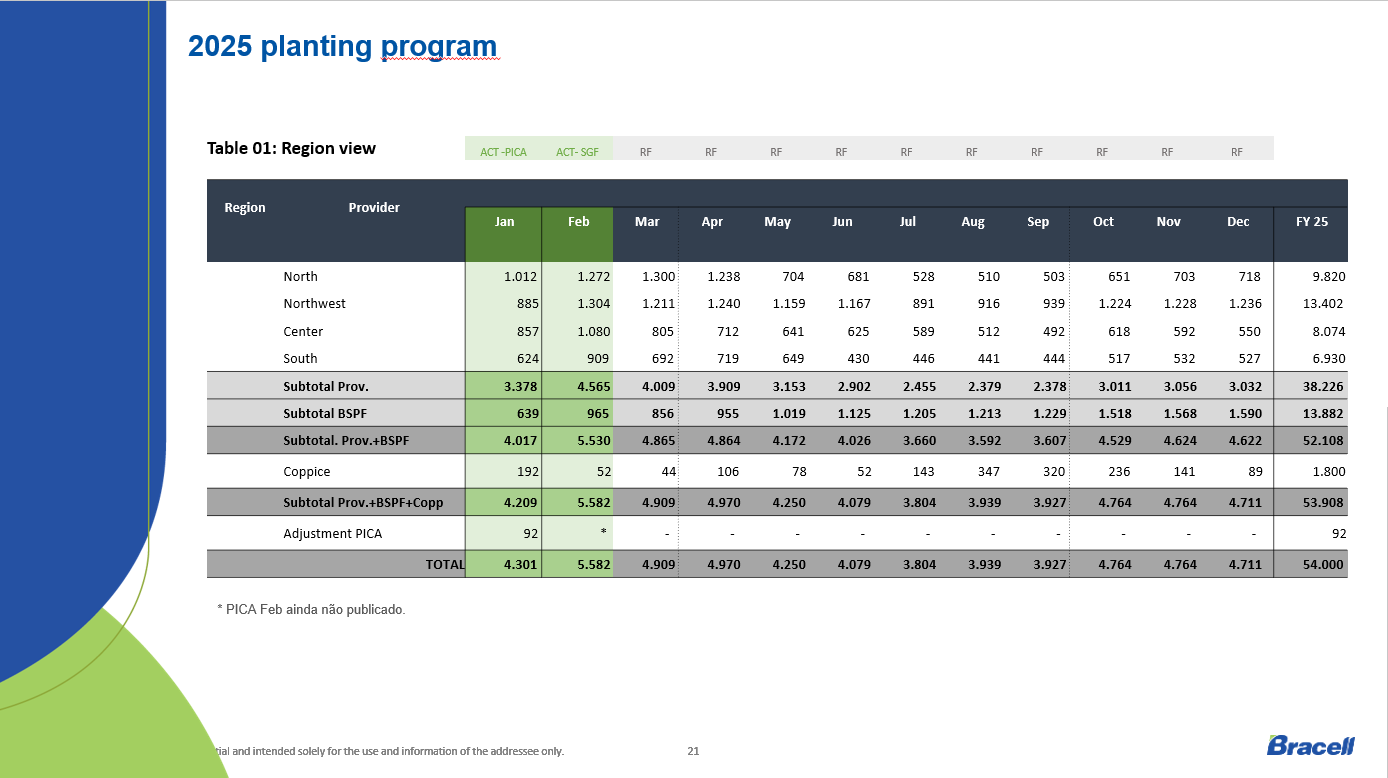